### Import main torch module and test if GPU avaliable

In [1]:
import torch


use_cuda = torch.cuda.is_available()
print("Using cuda? ", use_cuda)


Using cuda?  True


### Loading and taking a look to input images

data/train/melanoma/ISIC_0013762.jpg


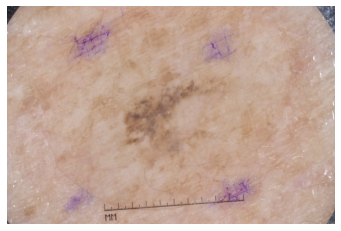

data/train/nevus/ISIC_0014805.jpg


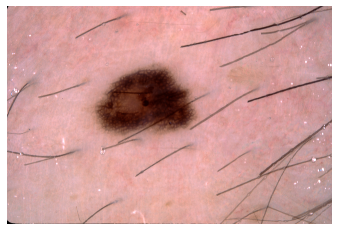

data/train/seborrheic_keratosis/ISIC_0014811.jpg


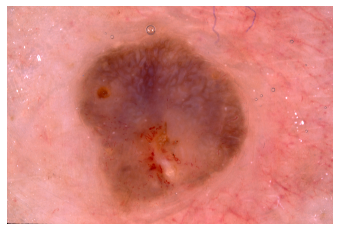

In [2]:
import os
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

### Taking a look of how a smaple image looks like

def imshow2(image):
    img = cv2.imread(image)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.axis('off')
    plt.show()

img_train_pth = "data/train/melanoma"
img_train_pth1 = "data/train/nevus"
img_train_pth2 = "data/train/seborrheic_keratosis"
sample_img = os.path.join(img_train_pth, os.listdir(img_train_pth)[0])
sample_img1 = os.path.join(img_train_pth1, os.listdir(img_train_pth1)[0])
sample_img2 = os.path.join(img_train_pth2, os.listdir(img_train_pth2)[0])

print(sample_img)
imshow2(sample_img)
print(sample_img1)
imshow2(sample_img1)
print(sample_img2)
imshow2(sample_img2)

### Image Transformation, dataset process and augmentation

In [13]:
import torch
from torchvision import datasets
from torchvision import transforms


img_size = 224 ## we will try first with vgg. The vgg model is trained with a default image size of 224

pixel_normalization = transforms.Normalize(  # Default intensity normalization values for vgg
    mean=[0.485, 0.456, 0.406], 
    std=[0.229, 0.224, 0.225]
)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),  ## Rando resize and random horizontal flipping for data augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    pixel_normalization
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    pixel_normalization
])

test_transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    pixel_normalization
])

train_data = datasets.ImageFolder("data/train/", transform=train_transform)
valid_data = datasets.ImageFolder("data/valid/", transform=valid_transform)
test_data = datasets.ImageFolder("data/test/", transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=24, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=24, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=24, shuffle=True)



### How processed data looks like

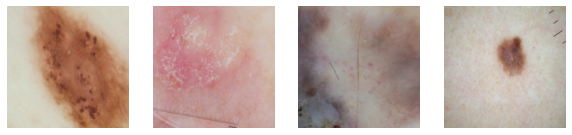

In [15]:
import numpy as np

def imshow_fromTensor(image, ax=None, title=None, normalize=True):
    """Imshow From Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.axis('off')
    
    
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(figsize=(10,4), ncols=4)

for ii in range(4):
    ax = axes[ii]
    imshow_fromTensor(images[ii], ax=ax)


### Model selection with transfer learnign and fine-tuning 

In [5]:
from torchvision import models
from torch import nn
from collections import OrderedDict 

vgg16 = models.vgg16(pretrained=True)
#print(vgg16)

## frezing feature layers
for param in vgg16.features.parameters():
    param.requires_grad = False
    
    
in_classifier_parameters = vgg16.classifier[0].in_features
n_out_classes = len(train_data.classes)

## Lets build the classifier part

classifier = nn.Sequential(OrderedDict([
    ("fc1", nn.Linear(in_classifier_parameters, 1024)), 
    ("relu", nn.ReLU()),
    ("drop", nn.Dropout()),
    ("fc2", nn.Linear(1024, 512)), 
    ("relu2", nn.ReLU()),
    ("fc3", nn.Linear(512, n_out_classes)), 
]))

vgg16.classifier = classifier
print(vgg16)

if use_cuda:
    vgg16.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Loss and optimizer

In [6]:
from torch import optim

criterion_entropy = nn.CrossEntropyLoss()

optimizer_adam = optim.Adam(vgg16.classifier.parameters(), lr=0.001)

### Training process 

In [67]:
def train(n_epochs, model, training_data_loader, validation_data_loader, criterion=criterion_entropy, optimizer=optimizer_adam, use_cuda=use_cuda, save_path="model_derma.pt"):
    
    valid_loss_min = np.Inf
    for epoch in range(1, 1+n_epochs):
        
        running_loss = 0
        valid_loss = 0
        valid_accuracy = 0
        
        model.train()
        
        for image_batch, target_batch in training_data_loader:
            
            if use_cuda:
                image_batch, target_batch = image_batch.cuda(), target_batch.cuda()
            
            optimizer.zero_grad()
            
            out = model.forward(image_batch)
            
            loss = criterion(out, target_batch)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item() 
            
        train_loss = running_loss/len(train_loader)

        model.eval()
        for image_batch, target_batch in validation_data_loader:
            
            if use_cuda:
                image_batch, target_batch = image_batch.cuda(), target_batch.cuda()
            
            out = model.forward(image_batch)
            
            ## Compute validation loss
            loss = criterion(out, target_batch)
            
            valid_loss += loss.item() 
            
            ## Compute validation accuracy
            top_p, top_class = out.topk(1, dim=1)
            equals = top_class == target_batch.view(*top_class.shape)                    
            valid_accuracy += torch.mean(equals.type(torch.FloatTensor))
            
        valid_loss = valid_loss/len(validation_data_loader)
        valid_accuracy = valid_accuracy/len(validation_data_loader)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValid Accuracy: {:.3f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            valid_accuracy
        ))
        
        if valid_loss < valid_loss_min:            
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss
            ))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    # return trained model
    return model
            

In [68]:
model_scratch = train(20, vgg16, train_loader, valid_loader, save_path="model_derma.pt")

Epoch: 1 	Training Loss: 0.740709 	Validation Loss: 0.813194 	Valid Accuracy: 0.643
Validation loss decreased (inf --> 0.813194).  Saving model ...
Epoch: 2 	Training Loss: 0.695455 	Validation Loss: 0.792675 	Valid Accuracy: 0.589
Validation loss decreased (0.813194 --> 0.792675).  Saving model ...
Epoch: 3 	Training Loss: 0.685176 	Validation Loss: 0.712895 	Valid Accuracy: 0.673
Validation loss decreased (0.792675 --> 0.712895).  Saving model ...
Epoch: 4 	Training Loss: 0.669743 	Validation Loss: 0.785522 	Valid Accuracy: 0.631
Epoch: 5 	Training Loss: 0.671837 	Validation Loss: 0.697471 	Valid Accuracy: 0.655
Validation loss decreased (0.712895 --> 0.697471).  Saving model ...
Epoch: 6 	Training Loss: 0.657954 	Validation Loss: 0.868695 	Valid Accuracy: 0.619
Epoch: 7 	Training Loss: 0.652450 	Validation Loss: 0.694870 	Valid Accuracy: 0.679
Validation loss decreased (0.697471 --> 0.694870).  Saving model ...
Epoch: 8 	Training Loss: 0.619831 	Validation Loss: 0.656935 	Valid Accu

### Test Process

In [9]:
import numpy as np

def test(loader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loader):
        data.shape
        
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

### First Results

In [16]:
vgg16.load_state_dict(torch.load('model_derma.pt'))
test(test_loader, vgg16, criterion_entropy, use_cuda)

Test Loss: 0.819817


Test Accuracy: 65% (395/600)
